# Laboratorium 1


### Konfiguracja

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
import json as js

### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [2]:
class PointsCollection:
    def __init__(self, points = [], color = None, marker = None):
        self.points = np.array(points)
        self.color = color
        self.marker = marker
        
class LinesCollection:
    def __init__(self, lines = [], color = None):
        self.color = color
        self.lines = lines
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        if self.color:
            return mcoll.LineCollection(self.lines, [mcolors.to_rgba(self.color)] * len(lines))
        else:
            return mcoll.LineCollection(self.lines)

class Plot:
    def __init__(self, points=[], lines=[], json = None):
        if json is None:
            self.points = points
            self.lines = lines
        else:
            self.points = [PointsCollection(pointsCol) for pointsCol in js.loads(json)["points"]]
            self.lines = [LinesCollection(linesCol) for linesCol in js.loads(json)["lines"]]
            
    def draw(self):
        ax = plt.axes()
        for collection in self.points:
            if collection.points.size > 0:
                ax.scatter(*zip(*collection.points), c=collection.color, marker=collection.marker)
        for collection in self.lines:
            ax.add_collection(collection.get_collection())
        ax.autoscale()
        plt.draw()
        
    def toJSON(self):
        return js.dumps({"points": [pointCol.points.tolist() for pointCol in self.points], 
                          "lines":[linesCol.lines for linesCol in self.lines]})

### Przykład użycia

<IPython.core.display.Javascript object>


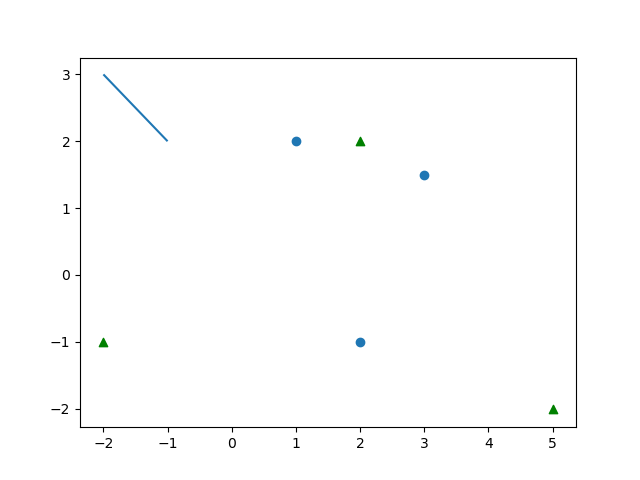

In [3]:
%matplotlib notebook

plot = Plot([PointsCollection([(1, 2), (3, 1.5), (2, -1)]), 
             PointsCollection([(5, -2), (2, 2), (-2, -1)], color = 'green', marker = "^")], 
            [LinesCollection([[(-1,2),(-2,3)]])])
plot.draw()

### Rozwiązanie

In [168]:
import random
import math
%matplotlib notebook

points_a = []
for i in range(0, 100000):
    points_a.append((random.random()*2000 - 1000, random.random()*2000 - 1000))
    
points_b = []
for i in range(0,100000):
    points_b.append((random.random()*(2* 10**14) - 10**14, random.random()*(2* 10**14) - 10**14))

points_c = []
for i in range(0, 1000):
    point_angle = random.random() * math.pi * 2
    points_c.append((math.cos(point_angle)*100, math.sin(point_angle)*100))
    
points_d = []
for i in range(0, 1000):
    x = random.random()*2000 - 1000
    points_d.append((x, 0.05 * x + 0.05))
    
def det1(a, b, c): # 3x3
    return a[0]*b[1] + a[1]*c[0] + b[0]*c[1] - c[0]*b[1] - a[0]*c[1] - b[0]*a[1]

def det2(a, b, c): # 2x2
    return (a[0] - c[0])*(b[1] - c[1]) - (b[0] - c[0])*(a[1] - c[1])

def det3(a, b, c): # 3x3 numpy
    a = np.array([[a[0], a[1], 1], [b[0], b[1], 1], [c[0], c[1], 1]])
    return np.linalg.det(a)

def det4(a, b, c): # 2x2 numpy
    a = np.array([[a[0]-c[0], a[1]-c[1]], [b[0]-c[0], b[1]-c[1]]])
    return np.linalg.det(a)

def getKey(point): # for sorting
    return point[0]

def binary_search(point, arr): # to make check_diff faster
    if len(arr) == 0:
        return False
    
    maxx = len(arr)-1
    minn = 0
    curr = (maxx + minn)//2
    
    while maxx-minn > 1:
        if arr[curr][0] == point[0]:
            if arr[curr][1] == point[1]:
                return True
            elif arr[curr][1] > point[1]:
                maxx = curr
            else:
                minn = curr
        elif arr[curr][0] > point[0]:
            maxx = curr
        else:
            minn = curr
            
        curr = (maxx + minn)//2
    
    return arr[minn]==point or arr[minn+1]==point
    
def check_side(points, det, eps, arr): # classifying points (left side of the line, right side or collinear)
    for point in points:
        curr_det = det((-1.0, 0.0), (1.0, 0.1), point)
        if curr_det - eps > 0:
            arr["left"].append(point)
        elif curr_det + eps < 0:
            arr["right"].append(point)
        else:
            arr["on"].append(point)

def check_diff_det(points, eps, det1, det2): # comparing 2 determinants
    different_points = []
    results_det1 = {"left": [], "on": [], "right": []}
    results_det2 = {"left": [], "on": [], "right": []}
    check_side(points, det1, eps, results_det1)
    check_side(points, det2, eps, results_det2)
    
    results_det1["left"].sort(key=getKey)
    results_det1["right"].sort(key=getKey)
    results_det1["on"].sort(key=getKey)
    results_det2["left"].sort(key=getKey)
    results_det2["right"].sort(key=getKey)
    results_det2["on"].sort(key=getKey)
    
    for point in points:
        if binary_search(point, results_det1["left"]):
            if not binary_search(point, results_det2["left"]):
                different_points.append(point)
                
        elif binary_search(point, results_det1["right"]):
            if not binary_search(point, results_det2["right"]):
                different_points.append(point)
    
    return different_points

def check_diff_eps(points, eps1, eps2, det): # comparing 2 different precisions
    different_points = []
    results_eps1 = {"left": [], "on": [], "right": []}
    results_eps2 = {"left": [], "on": [], "right": []}
    check_side(points, det, eps1, results_eps1)
    check_side(points, det, eps2, results_eps2)
    
    results_eps1["left"].sort(key=getKey)
    results_eps1["right"].sort(key=getKey)
    results_eps1["on"].sort(key=getKey)
    results_eps2["left"].sort(key=getKey)
    results_eps2["right"].sort(key=getKey)
    results_eps2["on"].sort(key=getKey)
    
    for point in points:
        if binary_search(point, results_eps1["left"]):
            if not binary_search(point, results_eps2["left"]):
                different_points.append(point)
                
        elif binary_search(point, results_eps1["right"]):
            if not binary_search(point, results_eps2["right"]):
                different_points.append(point)
    
    return different_points
    
def draw_points(points):
    Plot([PointsCollection(points)]).draw()

<IPython.core.display.Javascript object>


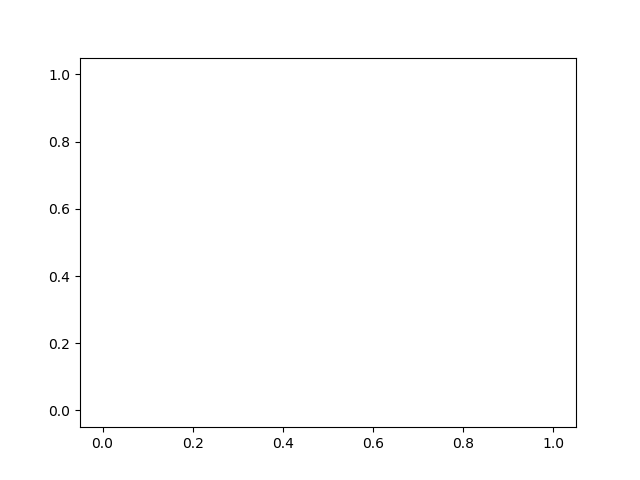

0
[]


In [172]:
# POINTS_A, det1 and det3, eps = 10**(-14)
%matplotlib notebook
difference = check_diff_det(points_a, 10**(-14), det1, det3)
draw_points(difference)
print(len(difference))
print(difference)

<IPython.core.display.Javascript object>


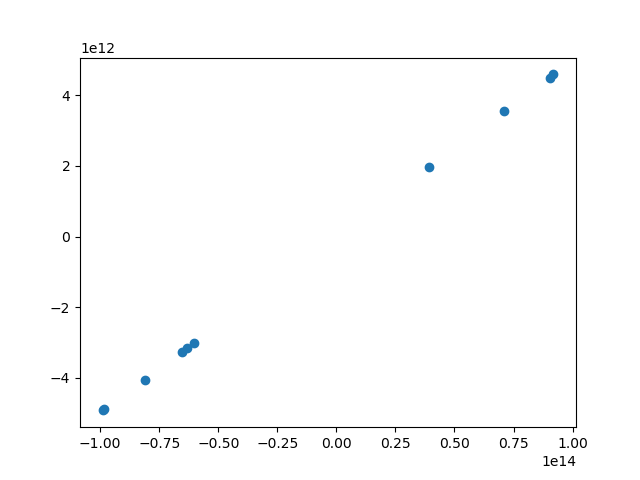

10
[(71004585619730.81, 3556520938754.828), (-60481580152695.71, -3028192503871.828), (-98581758512152.62, -4891013813247.797), (-98996575157323.89, -4925847706090.5625), (-63404391754980.25, -3160836171997.4688), (-80829986984488.1, -4051778461230.547), (90417152485663.78, 4479441770968.8125), (39159607115422.8, 1960665956591.5469), (-65308943009231.0, -3269000802356.0312), (91907165203966.94, 4592326369686.672)]


In [170]:
# POINTS_B, det1 and det2, eps = 10**(-14)
%matplotlib notebook
difference = check_diff_det(points_b, 10**(-14), det1, det2)
draw_points(difference)
print(len(difference))
print(difference)

<IPython.core.display.Javascript object>


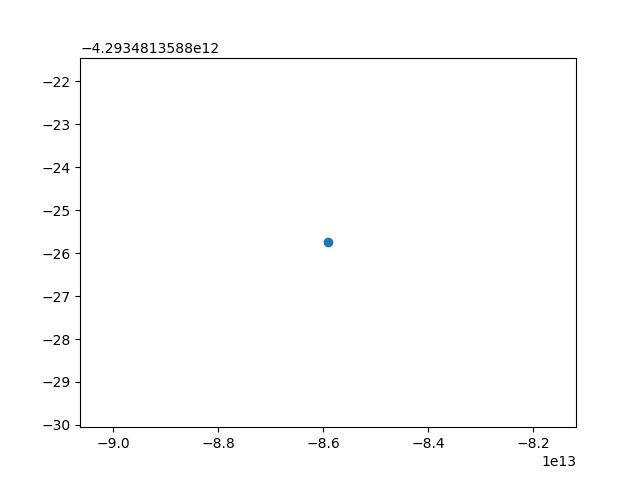

1
[(-85903285923684.64, -4293481358825.75)]


In [128]:
# POINTS_B, det1 and det4, eps = 10**(-14)
%matplotlib notebook
difference = check_diff_det(points_b, 10**(-14), det1, det4)
draw_points(difference)
print(len(difference))
print(difference)

<IPython.core.display.Javascript object>


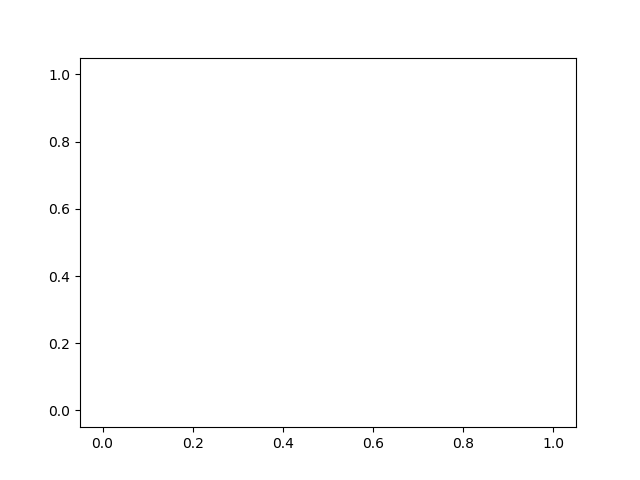

0
[]


In [144]:
# POINTS_C, det2 and det3, eps = 10**(-14)
%matplotlib notebook
difference = check_diff_det(points_c, 10**(-14), det2, det3)
draw_points(difference)
print(len(difference))
print(difference)

<IPython.core.display.Javascript object>


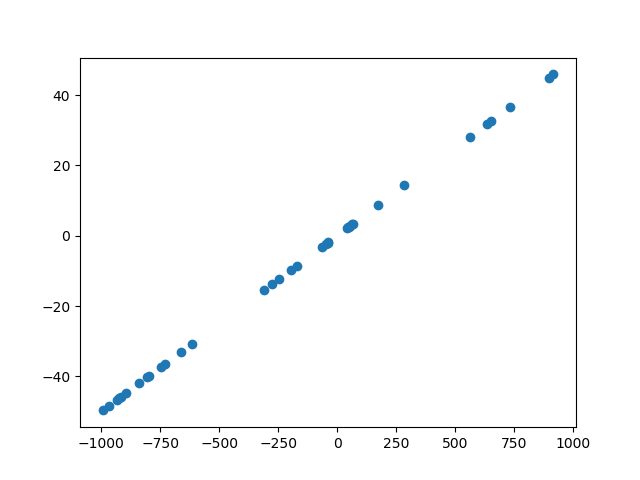

36
[(62.9227540497277, 3.196137702486385), (-969.1898128487479, -48.409490642437405), (-310.8551689614121, -15.492758448070607), (731.3962141930251, 36.619810709651254), (68.45233081523656, 3.472616540761828), (-799.3454193129521, -39.91727096564761), (48.167380853790064, 2.4583690426895033), (562.1641598469259, 28.1582079923463), (-194.96581200152923, -9.698290600076461), (41.37173192477576, 2.1185865962387878), (-246.7604849272542, -12.28802424636271), (-841.1772116002462, -42.00886058001232), (284.86897040453914, 14.293448520226958), (916.4715670291814, 45.873578351459074), (-616.1009876398705, -30.755049381993526), (-276.3429997119347, -13.767149985596735), (-730.6137863959418, -36.480689319797094), (-924.3252611745233, -46.16626305872617), (-994.449393614919, -49.672469680745955), (-917.9542865488934, -45.84771432744468), (173.72651392122248, 8.736325696061124), (650.8855957891678, 32.59427978945839), (-896.2347276228724, -44.76173638114362), (-38.79922994910271, -1.88996149745513

In [152]:
# POINTS_D, det2 and det4, eps = 10**(-14)
%matplotlib notebook
difference = check_diff_det(points_d, 10**(-14), det2, det4)
draw_points(difference)
print(len(difference))
print(difference)

<IPython.core.display.Javascript object>


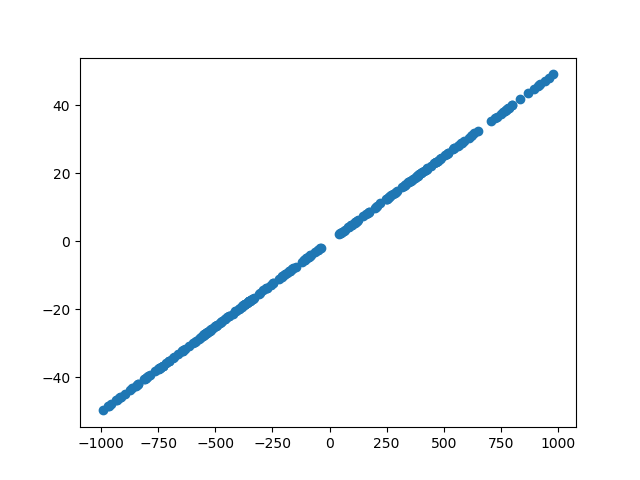

262
[(781.0082171734741, 39.100410858673705), (962.5383932072068, 48.17691966036034), (-788.5562221608815, -39.37781110804408), (379.00275296452423, 19.000137648226215), (62.9227540497277, 3.196137702486385), (270.8217058843602, 13.591085294218011), (-348.8985337838517, -17.394926689192584), (-837.4580681960426, -41.82290340980214), (318.2680991148809, 15.963404955744046), (-363.09342314036667, -18.104671157018334), (565.6775287563489, 28.333876437817448), (-809.1368535094288, -40.406842675471445), (-969.1898128487479, -48.409490642437405), (623.4679892384145, 31.223399461920724), (-370.0650448821947, -18.453252244109734), (-424.98135575254037, -21.19906778762702), (799.0681432025024, 40.00340716012512), (425.9631395456106, 21.34815697728053), (771.6173894528092, 38.63086947264046), (-310.8551689614121, -15.492758448070607), (-873.5898885195719, -43.6294944259786), (360.6733013562741, 18.08366506781371), (731.3962141930251, 36.619810709651254), (95.44013667241506, 4.822006833620753), (

In [153]:
# POINTS_D, det2 and det3, eps = 10**(-14)
%matplotlib notebook
difference = check_diff_det(points_d, 10**(-14), det2, det3)
draw_points(difference)
print(len(difference))
print(difference)

<IPython.core.display.Javascript object>


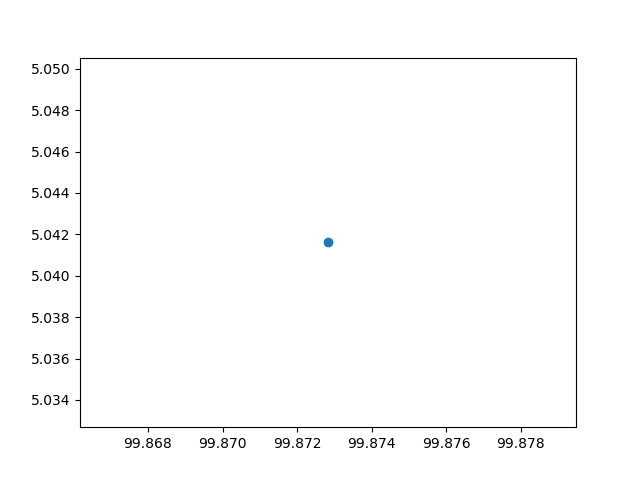

1
[(99.87282985062349, 5.041612601976532)]


In [155]:
# POINTS_C, det1, eps1 = 10**(-14), eps2 = 0.1
%matplotlib notebook
difference = check_diff_eps(points_c, 10**(-14), 0.1, det1)
draw_points(difference)
print(len(difference))
print(difference)

<IPython.core.display.Javascript object>


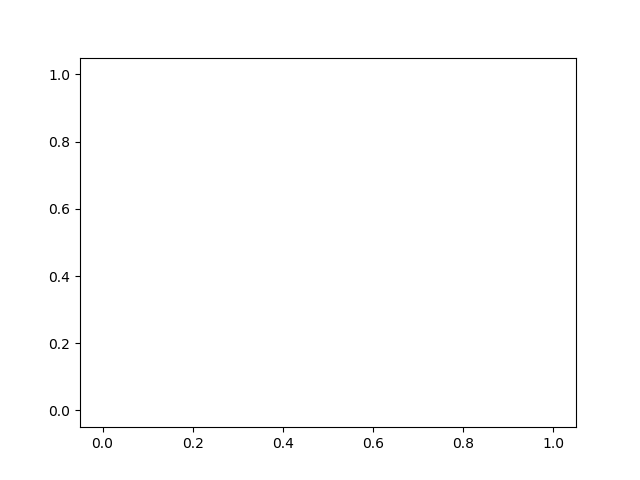

0
[]


In [167]:
# POINTS_D, det1, eps1 = 10**(-14), eps2 = 10**(-12)
%matplotlib notebook
difference = check_diff_eps(points_d, 10**(-12), 1, det1)
draw_points(difference)
print(len(difference))
print(difference)

<IPython.core.display.Javascript object>


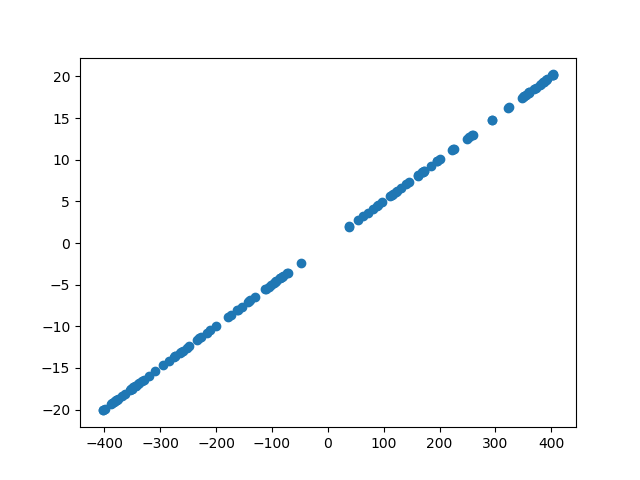

127
[(-375.20779318195616, -18.710389659097807), (225.40891726438736, 11.32044586321937), (-368.30353400948263, -18.36517670047413), (38.59900961669223, 1.9799504808346116), (351.73890699037224, 17.636945349518612), (-71.93908266739334, -3.5469541333696673), (-216.67690418465372, -10.783845209232686), (170.46664141261522, 8.573332070630762), (139.74750361728024, 7.037375180864013), (401.9899382730555, 20.149496913652776), (-252.54857285465062, -12.577428642732531), (224.6499526989785, 11.282497634948927), (-261.6524216217524, -13.03262108108762), (88.11613191020274, 4.455806595510137), (-96.4809715117625, -4.774048575588126), (-153.8464489305975, -7.642322446529875), (-101.1890843070504, -5.009454215352521), (-332.4613073766583, -16.573065368832914), (347.3033649712704, 17.41516824856352), (122.59838715519982, 6.179919357759991), (-402.89358248580106, -20.094679124290053), (324.5768273425399, 16.278841367126997), (-382.2577334999837, -19.062886674999184), (-85.7511855398825, -4.2375592

In [171]:
# POINTS_D, det2, eps1 = 10**(-14), eps2 = 10**(-12)
%matplotlib notebook
difference = check_diff_eps(points_d, 10**(-14), 10**(-12), det2)
draw_points(difference)
print(len(difference))
print(difference)